In [310]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [311]:
from PIL import Image, ImageDraw, ImageOps

In [46]:
def Double_circle(radius, img_array):
    # init vars
    radius
    switch = 3 - (2 * radius)
    points = []
    x = 0
    y = radius
    # first quarter/octant starts clockwise at 12 o'clock
    while x <= y:
        # first quarter first octant
        points.append(int(img_array[x,-y]+img_array[x+1,-y-1])/2)
        # first quarter 2nd octant
        points.append(int(img_array[y,-x]+img_array[y+1,-x-1])/2)
        # second quarter 3rd octant
        points.append(int(img_array[y,x]+img_array[y+1,x+1])/2)
        # second quarter 4.octant
        points.append(int(img_array[x,y]+img_array[x+1,y+1])/2)
        # third quarter 5.octant
        points.append(int(img_array[-x,y]+img_array[-x-1,y+1])/2)
        # third quarter 6.octant
        points.append(int(img_array[-y,x]+img_array[-y-1,x+1])/2)
        # fourth quarter 7.octant
        points.append(int(img_array[-y,-x]+img_array[-y-1,-x-1])/2)
        # fourth quarter 8.octant
        points.append(int(img_array[-x,-y]+img_array[-x-1,-y-1])/2)
        if switch < 0:
            switch = switch + (4 * x) + 6
        else:
            switch = switch + (4 * (x - y)) + 10
            y = y - 1
        x = x + 1
    sorted=[]
    for j in range(8):
        if j % 2 != 0:
            sorted.append(points[j-8::-8])
        else:
            sorted.append(points[j::8])
                
    return sum(sorted, []) #flatten method

In [290]:
def Triple_circle(radius, img_array):
    # init vars
    radius
    switch = 3 - (2 * radius)
    points = []
    x = 0
    y = radius
    # first quarter/octant starts clockwise at 12 o'clock
    while x <= y:
        # first quarter first octant
        points.append(int(img_array[x,-y]+img_array[x+1,-y-1]+img_array[x-1,-y+1])/3)
        # first quarter 2nd octant
        points.append(int(img_array[y,-x]+img_array[y+1,-x-1]+img_array[y-1,-x+1])/3)
        # second quarter 3rd octant
        points.append(int(img_array[y,x]+img_array[y+1,x+1]+img_array[y-1,x-1])/3)
        # second quarter 4.octant
        points.append(int(img_array[x,y]+img_array[x+1,y+1]+img_array[x-1,y-1])/3)
        # third quarter 5.octant
        points.append(int(img_array[-x,y]+img_array[-x-1,y+1]+img_array[-x+1,y-1])/3)
        # third quarter 6.octant
        points.append(int(img_array[-y,x]+img_array[-y-1,x+1]+img_array[-y+1,x-1])/3)
        # fourth quarter 7.octant
        points.append(int(img_array[-y,-x]+img_array[-y-1,-x-1]+img_array[-y+1,-x+1])/3)
        # fourth quarter 8.octant
        points.append(int(img_array[-x,-y]+img_array[-x-1,-y-1]+img_array[-x+1,-y+1])/3)
        if switch < 0:
            switch = switch + (4 * x) + 6
        else:
            switch = switch + (4 * (x - y)) + 10
            y = y - 1
        x = x + 1

    sorted=[]
    for j in range(8):
        if j % 2 != 0:
            sorted.append(points[j-8::-8])
        else:
            sorted.append(points[j::8])

    return sum(sorted, [])

In [4]:
def pre_processing(image, size):
    image = image.resize((size, size), Image.LANCZOS)
    gray_image = image.convert('L')
    gray_array = np.asarray(gray_image)
    
    return gray_array

In [162]:
def rotate(l, n):
    return l[n:] + l[:n]

In [291]:
def circle_mean_binary(gray_array):
    
    radius = len(gray_array)//2
    
    p = []
    for i in range(radius): 
        p.append(np.asarray(Triple_circle(i, gray_array)))
    
    b = []
    for i in range(len(p)):
        temp = []
        for j in range(len(p[i])):
            if p[i][j] >= p[i].sum()/len(p[i]):
                temp.append(1)
            else:
                temp.append(0)
        b.append(temp)
    
    return b

In [195]:
def cHash(image, size=256):
    
    gray_array = pre_processing(image, size)
    
    radius = len(gray_array)//2 #radius = image//2
    
    p = []
    for i in range(radius): 
        p.append(np.asarray(Double_circle(i, gray_array)))
        
    b=[]
    for i in range(len(p)):
        temp = []
        for j in range(len(p[i])):
            if p[i][j] >= p[i].sum()/len(p[i]):
                temp.append(1)
            else:
                temp.append(0)
        b.append(temp)
    
    d=[]
    for i in range(len(b)):
        e=[]
        for j in range(len(b[i])):
            e.append(rotate(b[i], j))
        d.append(e)
    
    #循環ハッシュを求める
    c=[]
    for i in tqdm(range(len(b))):
        check = 0
        for j in range(len(b[i])):
              check += np.sum(np.logical_xor(b[i], d[i][j] == False))
        c.append(check)
    
    return c

In [321]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [174]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [306]:
def differential_angle_value(main, sub, size=256):
        
    array_main = pre_processing(main, size)
    array_sub = pre_processing(sub, size)
    
    radius = len(array_main)//2 #radius = image//2
    
    bin_main = circle_mean_binary(array_main) 
    bin_sub = circle_mean_binary(array_sub)
    
    c=[]
    start = int(radius*0.5)
    end = int(radius*0.6)
    for i in tqdm(range(start, end)):#len(bin_main))):
        check = []
        for j in range(len(bin_main[i])):
              check.append(np.sum(np.logical_xor(bin_main[i], rotate(bin_sub[i],j)) == False))
        c.append(check)
    
    temp = 0
    cut = 0
    test = []
    for i in range(len(c)):
        np_c = np.array(c[i])
        temp += np_c.argmax()
        test.append(np_c.argmax()/len(np_c))
    angle = temp/(end-start)
    
    answer=reject_outliers(np.array(test)).flatten()
    
    '''
    posi = 0
    nega = 0
    for i , ans in enumerate(answer):
        if ans > 0.5:
            answer[i] = abs(1-answer[i])
            nega +=1
        else:
            posi +=1
    '''
        
    print(test)
    print(answer)
    print(np.sum(answer)/answer.size*360)
    
    return c, angle

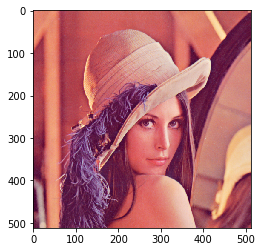

In [134]:
lena = Image.open(r'data/lena.png')
lena_array = np.asarray(lena)
plt.imshow(lena_array)

(174, 191, 4)

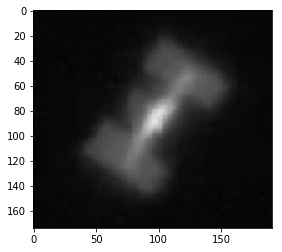

In [322]:
iss_lights = Image.open(r'data/iss_lights.png')
iss_array = np.asarray(iss_light)
plt.imshow(iss_array)
iss_array.shape

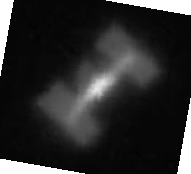

In [330]:
iss_20deg = iss_lights.rotate(350)
iss_20deg

In [331]:
iss_20deg.save('data/iss_350deg.png')

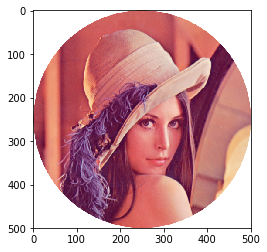

In [10]:
lena_circle = Image.open(r'data/lena_circle.png')
lena_circle_array = np.asarray(lena_circle)
plt.imshow(lena_circle_array)

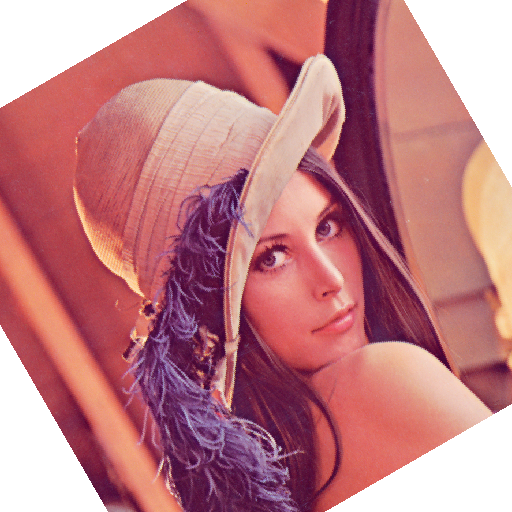

In [288]:
lena_30deg = lena.rotate(30)
lena_30deg

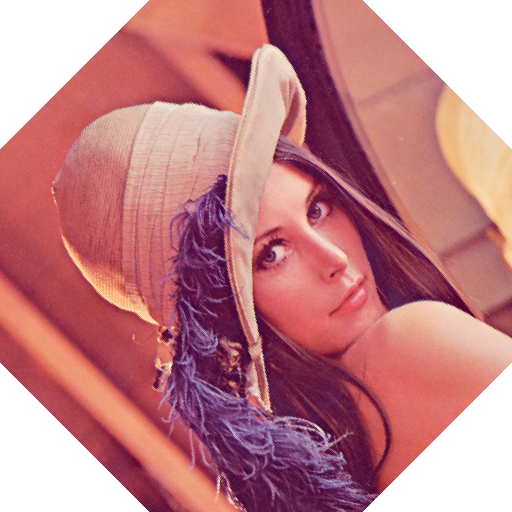

In [287]:
lena_45deg = lena.rotate(45)
lena_45deg

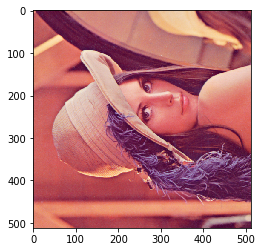

In [12]:
lena_left = Image.open(r'data/lena_left.png')
lena_left_array = np.asarray(lena_left)
plt.imshow(lena_left_array)

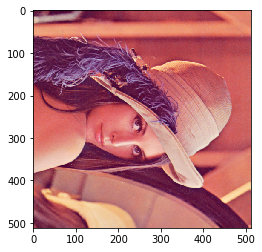

In [13]:
lena_right = Image.open(r'data/lena_right.png')
lena_right_array = np.asarray(lena_right)
plt.imshow(lena_right_array)

In [304]:
lena_mirror = ImageOps.mirror(lena)

In [309]:
c , angle = differential_angle_value(lena, lena_left)
angle

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in ubyte_scalars
  del sys.path[0]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_l

[0.24728260869565216, 0.2473404255319149, 0.25, 0.24739583333333334, 0.24744897959183673, 0.2475, 0.2475, 0.24754901960784315, 0.24759615384615385, 0.24759615384615385, 0.24764150943396226, 0.24768518518518517]
[0.24734043 0.24739583 0.24744898 0.2475     0.2475     0.24754902
 0.24759615 0.24759615 0.24764151 0.24768519]
89.1091173735498


98.91666666666667

In [44]:
for i in tqdm(range(len(c))):
    y = c[i]
    x = np.linspace(0, 360, len(c[i]))
    
    plt.figure(figsize=(12, 9))
    
    plt.grid(which='major',color='black',linestyle='-')
    plt.xlim([0, 360])
    plt.xticks([0,30,60,90,120,150,180,210,240,270,300,330,360])
    plt.tick_params(length=0)
    
    plt.title("lenna vs. lenna_30deg" + str(i+1))
    plt.xlabel('angle[deg]')
    plt.ylabel('Matched binary number')
    
    plt.plot(x,y)
    
    plt.savefig('lena_angle/lena_30deg/lena_30deg' + str(i) + '.png')
    plt.clf()

100%|██████████| 128/128 [00:43<00:00,  2.63it/s]


<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

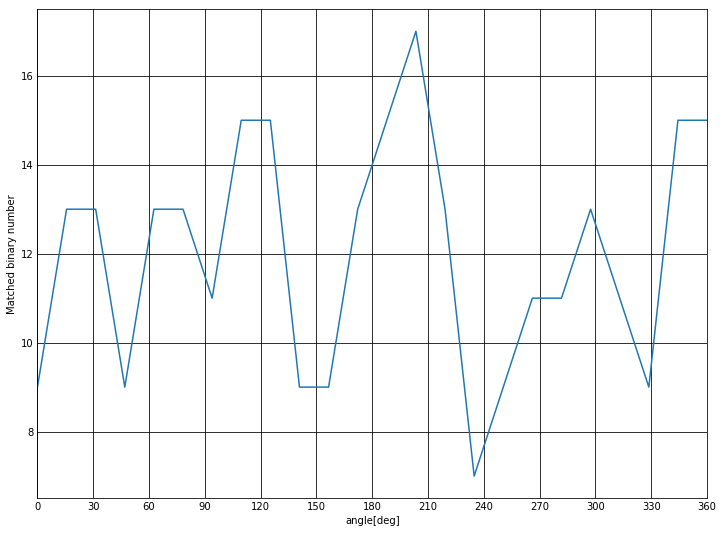

In [16]:
i = 3
y= c[i]
x = np.linspace(0, 360, len(c[i]))

plt.figure(figsize=(12, 9))
plt.grid(which='major',color='black',linestyle='-')
plt.xlim([0, 360])
plt.xticks([0,30,60,90,120,150,180,210,240,270,300,330,360])
plt.tick_params(length=0)
plt.xlabel('angle[deg]')
plt.ylabel('Matched binary number')
plt.plot(x,y)

In [17]:
i=40
np_c = np.array(c[i])
np_c.argmax()

IndexError: list index out of range

In [ ]:
max(c[i])

In [ ]:
360/len(c[i])*np_c.argmax()

In [ ]:
temp = 0
cut = 125

for i in range(cut, len(c)):
    np_c = np.array(c[i])
    temp += 360/len(c[i])*np_c.argmax()
temp/(len(c)-cut)